# Model Tuning

This notebook will demonstate how to automatically tune model hyperparameters for predictions accuracy.

## Set-Up
We will begin with some imports

In [1]:
import autompc as ampc
import numpy as np

Loading AutoMPC...
Finished loading AutoMPC


And we will then generate some training data using the benchmark.

In [2]:
from autompc.benchmarks import CartpoleSwingupV2Benchmark

benchmark = CartpoleSwingupV2Benchmark()

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

## Creating the Task

The first things we need to do is create a Task.  The Task object encapsulates all the information the tuner needs to evaluate controllers.  The Task includes an OCP, as well as additional information such as the initial and termination conditions.

Let's create an OCP using the ThresholdCost and add relevant control bounds.

In [3]:
from autompc.costs import ThresholdCost

ocp = ampc.OCP(system)
ocp.set_cost(ThresholdCost(system, goal=np.zeros(system.obs_dim), threshold=0.2, observations=["theta", "omega"]))
ocp.set_ctrl_bound("u", -20.0, 20.0)

Next, we create the Task, associating it with the OCP and other relevant information

In [4]:
task = ampc.Task(system)
task.set_ocp(ocp)
task.set_init_obs(np.array([np.pi, 0.0, 0.0, 0.0]))
task.set_num_steps(200)

## Setting Up a Controller

First, we need to create the controller to be tuned.  We can give the controller several options for the model and optimizer.  The tuner will automatically select between these.  We also add an OCP Factory, which allows the tuner to construct a new OCP with tuned weights.

In [5]:
from autompc.sysid import MLP, SINDy
from autompc.optim import IterativeLQR, MPPI
from autompc.ocp import QuadCostFactory

controller = ampc.Controller(system)
controller.add_model(MLP(system))
controller.add_model(SINDy(system))
controller.add_optimizer(IterativeLQR(system))
controller.add_optimizer(MPPI(system))
controller.add_ocp_factory(QuadCostFactory(system))

We can see that this gives a joint configuration space over all algorithm options.  This defines the search space for the tuner.

In [6]:
controller.get_config_space()

Configuration space object:
  Hyperparameters:
    IterativeLQR:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    MLP:hidden_size_1, Type: UniformInteger, Range: [16, 256], Default: 128
    MLP:hidden_size_2, Type: UniformInteger, Range: [16, 256], Default: 128
    MLP:hidden_size_3, Type: UniformInteger, Range: [16, 256], Default: 128
    MLP:hidden_size_4, Type: UniformInteger, Range: [16, 256], Default: 128
    MLP:lr, Type: UniformFloat, Range: [1e-05, 1.0], Default: 0.001, on log-scale
    MLP:n_hidden_layers, Type: Categorical, Choices: {1, 2, 3, 4}, Default: 2
    MLP:nonlintype, Type: Categorical, Choices: {relu, tanh, sigmoid, selu}, Default: relu
    MPPI:horizon, Type: UniformInteger, Range: [5, 30], Default: 20
    MPPI:lmda, Type: UniformFloat, Range: [0.1, 2.0], Default: 1.0
    MPPI:num_path, Type: UniformInteger, Range: [100, 1000], Default: 200
    MPPI:sigma, Type: UniformFloat, Range: [0.0001, 2.0], Default: 1.0
    QuadCostFactory:dx_F, Type: UniformFlo

## Creating the Tuner

Next, we will create a `ControlTuner`, which will search the joint controller configuration space.  The `ControlTuner` evaluates controller configurations by simulating them against a learned surrogate model.  There are a few options we can choose for how to construct the surrogate model.  Here we set the surrogate mode to `default`, which means the `ControlTuner` will learn the surrogate model according to the default configuration of a given model.  We then pass an `MLP` instance as the surrogate model to be trained and set the `surrogate_split` to 0.5.  Which means half the trajectories will be used for training the surrogate model, and half for training the controller.  Finally, we specify an `output_dir` where AutoMPC will store intermediate and output files.  If the output directory is not specified, AutoMPC will automatically create one in the current working directory.

In [7]:
from autompc.tuning import ControlTuner
from autompc.sysid import MLP

tuner = ControlTuner(surrogate_mode="default", surrogate=MLP(system), surrogate_split=0.5)

/usr/lib/python3/dist-packages/pyparsing.py:1745: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


Another important surrogate mode to be aware of is `autoselect`.  This mode will automatically tune and select the surrogate model before tuning the controller.  This is a great option if you are not sure which model will work well, but it will take significantly longer to run.

## Running the Tuner

Now, we can run the tuner.  We pass the `Controller` to be tuned, the `Task` which specifies the tuning objective, and the trajectory set, which will be randomly partitioned into a surrogate training set and a controller training set.  Additional arguments include
 * **n_iters** : The number of configurations to evalute during tuning.
 * **rng** : Numpy random number generator
 * **output_dir** : AutoMPC output and intermediary files are stored here.  If not specified, a directory is automatically created in the current workdir.
 * **truedyn** : For benchmarking purposes, we can pass a function which computes the true dynamics, so we can evalaute the accuracy of the surrogate model in measuring controller performance.
 
 The tuner returns the tuned controller, and a `ControlTunerResult` instance which stores information about the tuning run.

In [ ]:
tuned_controller, tune_result = tuner.run(
    controller,
    task,
    trajs,
    n_iters=200,
    rng=np.random.default_rng(100),
    output_dir="6_controller_tuning_example_output/",
    truedyn=benchmark.dynamics
)

/home/william/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]

Adding unsupported scenario options: {'save_results_instantly': True}


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


Target Algorithm returned NaN or inf as quality. Algorithm run is treated as CRASHED, cost is set to 2147483647.0 for quality scenarios. (Change value through "cost_for_crash"-option.)


CfgRunner: Exception during evaluation
Exit code:  1


## Exploring the Tuning Results

AutoMPC provides tools based on matplotlib to visualize the results of a tuning run.  Here, we visualize the tuning curve, which shows the surrogate-estimated performance of best controller found after each iteration of tuning.  When the `truedyn` argument is provided to the tuner, this graph also plots the true dynamics performance.

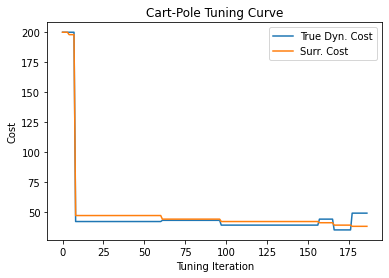

In [10]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result)
ax.set_title("Cart-Pole Tuning Curve")
plt.show()

To further analyze the results of a tuning run, we can inspect the fields of the `ControlTuneResult` object.  Key fields include
 * **inc_cfg** : The final incumbent (selected) configuration.
 * **inc_cfgs** : A list of the incumbent configurations at each iteration.
 * **inc_costs** : The incumbent cost at each iteration.
 * **cfgs** : A list of the configurations evaluated at each iteration.
 * **costs** : A list of the costs of configruations evaluated at each iteration.

For more detailed documentation, see the API reference.

## Resuming a Tuning Run

If a tuning run is interrupted partway through, you can resume by calling `tuner.run` with the keyword argument `restore_dir` containing the output directory of the original run.  The feature can also be used to increase or decrease the tuning iterations of a tuning run that is already in progress.